# iLykei Lecture Series

# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Reinforcement Learning

## Notebook 5: Learning Simplified Pac-Man with Q-Learning

## Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2018

##### Main text: Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc



This notebook shows how to make an agent to self-learn playing reduced Pac-Man game using Q-Learning method.

Install package *pyglet* by executing in terminal window:

*conda install -c conda-forge pyglet*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import pyglet

# The game

Here is a simplified realization of famous Ms. Pac-Man game. 

The agent is represented by `☺`, which can move in any direction inside the field except for walls `▒`. <br>
Each move earns `1` point. Agent can collect diamonds `♦`, each diamond earns extra `10` points. So, score earned by one move (`reward`) is either 1 (no diamond) or 11 (with diamond). <br> 

On the field there are also monsters `☢`, their objective is to catch the agent. <br>
Monsters move in random directions until the agent is within the `monster_vision_range`, then monster moves exactly in the direction of the agent. 

The game ends when monster touches the agent or when the agent is still alive after 100 moves.

Create a game with 10x10 field, 2 monsters, 3 diamonds and 4 walls.

In [2]:
from mini_pacman import PacmanGame

env = PacmanGame(field_shape=(10,10), nmonsters=2,
                 ndiamonds=3, nwalls=4, monster_vision_range=1)
#env.print_field()  # will print a picture in text symbols
env.render()  # creates graphical rendering of the field

Player can control agent using actions from `1` to `9` according tp the following table:

In [3]:
from tabulate import tabulate
print(tabulate([[1,'Down-Left'], \
                [2,'Down'], \
                [3,'Down-Right'], \
                [4,'Left'], \
                [5,'No Move'], \
                [6,'Right'], \
                [7,'Up-Left'], \
                [8,'Up'], \
                [9,'Up-Right']], \
               headers = ['Action Code','Move'], \
              tablefmt='orgtbl'))

|   Action Code | Move       |
|---------------+------------|
|             1 | Down-Left  |
|             2 | Down       |
|             3 | Down-Right |
|             4 | Left       |
|             5 | No Move    |
|             6 | Right      |
|             7 | Up-Left    |
|             8 | Up         |
|             9 | Up-Right   |


Execute actions in the following cell several times to see how easy/difficult it is to stay alive.

In [28]:
obs = env.make_action(4)
env.render()

Function `make_action()` returns a dictionary containing current observation of the game (all coordinates, possible agent actions, reward and total score):

In [29]:
obs

{'reward': 11,
 'total_score': 65,
 'end_game': False,
 'player': (6, 2),
 'monsters': [(1, 1), (1, 8)],
 'diamonds': [(1, 2), (2, 8), (3, 2)],
 'walls': [(0, 2), (1, 5), (3, 0), (9, 2)],
 'possible_actions': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

Current observation can also be reached using `get_obs()` method of `PacmanGame` object.

In [30]:
env.get_obs()

{'reward': 11,
 'total_score': 65,
 'end_game': False,
 'player': (6, 2),
 'monsters': [(1, 1), (1, 8)],
 'diamonds': [(1, 2), (2, 8), (3, 2)],
 'walls': [(0, 2), (1, 5), (3, 0), (9, 2)],
 'possible_actions': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

Game can be restarted using `env.reset()` or by creating new instance of `PacmanGame` object. `env.reset()` returns an observation of restarted game.

Try to run the game several times against the environment selecting random actions. What scores do you observe?

In [31]:
# Render random-action game
obs = env.reset()
while not obs['end_game']:
    action = random.choice(obs['possible_actions'])
    obs = env.make_action(action)
    env.render()
    time.sleep(0.5)

Play 100 games using random action strategy and find average score.

In [32]:
game_scores=[]
for one_game in range(100):
    obs = env.reset()
    while not obs['end_game']:    
        action = random.choice(obs['possible_actions'])
        obs = env.make_action(action)
    game_scores.append(obs['total_score'])
print('Mean: ',np.mean(game_scores),'\nMedian: ',np.median(game_scores))

Mean:  21.83 
Median:  13.5


Close the game (including window):

In [33]:
env.close()

The goal of the project is to let agent learn a strategy that maximizes its total score; use random action strategy as a benchmark.

# Markov Decision Process and Q-Learning

## Bellman equation

This game fits the framework of dynamic programing and can be solved using [Markov Decision Process](https://en.wikipedia.org/wiki/Markov_decision_process). Indeed, given current state and current action, distribution of future states and rewards do not depend on previous states, rewards and actions. 

Suppose the agent tries to maximize the discounted future rewards (or discounted total score in our case), that is $\sum_t \gamma^t R_t$, where $R_t$ is a reward at time $t=1,2,\ldots$ and $\gamma\in[0,1]$ is a discount coefficient (which can be chosen arbitrarily).

Suppose there exists a function $Q(s,a)$ that shows expected discounted future rewards, given that the agent acts optimally, the current state is $s$ and the agent choses action $a$. Then, according to the result obtained by Richard Bellman, such function satisfies the Bellman equation:

$$
Q(s,a) = \sum_{s'} P(s,a,s') \left( R(s,a,s') + \gamma \cdot \max_{a'} Q(s',a') \right),
$$

where 
+ the sum is taken over all possible states $s'$ and maximum is taken over all actions $a'$ available at state $s'$; 
+ $P(s,a,s')$ is the probability to get into state $s'$ over 1 step if an agent is in state $s$ and choses action $a$; 
+ $R(s,a,s')$ is a reward given for moving from state $s$ to state $s'$ with action $a$.

## Q-value iterations

A natural way to solve this equation is a **Q-Value iteration algoithm**:

1. $Q_0(s,a) = 0$ for all state-action pairs $(s,a)$;
2. $Q_{n+1}(s,a) = \sum_{s'} P(s,a,s') \left( R(s,a,s') + \gamma \cdot \max_{a'} Q_n(s',a') \right)$ for all state-action pairs $(s,a)$, $n=1,2,\ldots$.

Note that the solution requires calculating all transition probabilities $P(s,a,s')$. In the Pac-Man game above these probabilities can be calculated analytically because we know that monsters move randomly. However, that is not the case in general. 

## Q-learning

**Q-Learning** algorithm is an adaptation of the Bellman algorithm for the unknown behavior of the environment. 

The agent uses some _exploration policy_ while interacting with the graph of the game and updates estimates of Q-Values for current state $s$ and chosen action $a$ at each step:
$$
Q_{n+1} (s,a) = (1-\alpha) Q_n (s,a) + \alpha \left(R + \gamma \cdot \max_{a'} Q_n(s',a')\right),
$$

where $s'$ is the state where an agent turned out to be after chosing action $a$ and $\alpha\in (0,1)$ is a learning rate.

A common _exploration policy_ is the so called **$\varepsilon$-greedy strategy**. $\varepsilon$-greedy strategy is a mix of a random strategy selected with probability $\varepsilon$ and a greedy strategy that always choses highest known Q-Value action with probability $(1-\varepsilon)$.

## Using Q-Learning for PacmanGame

Create a simple game with parameters:

In [34]:
FIELD_SHAPE = (4, 4)
N_MONSTERS = 1
N_DIAMONDS = 1
N_WALLS = 0
MONSTER_VISION_RANGE = 1

env = PacmanGame(field_shape=FIELD_SHAPE, nmonsters=N_MONSTERS,
                 ndiamonds=N_DIAMONDS, nwalls=N_WALLS,
                 monster_vision_range=MONSTER_VISION_RANGE)

## Random strategy

First, find total scores if the agent uses purely random strategy. It is going to be the initial benchmark.

In [35]:
n_games = 1000

scores = []
for i in range(n_games):
    obs = env.reset()  # restart the game
    while not obs['end_game']:
        action = random.choice(obs['possible_actions'])
        obs = env.make_action(action)
        scores.append(obs['total_score'])

Since `scores` are rather noisy, smooth them using moving-average and plot:

In [36]:
def moving_average(v, window=100):
    out = []
    for j in range(len(v)):
        out.append(sum(v[max(j-window+1, 0):j]) / (min(j, window) + 1))
    return out

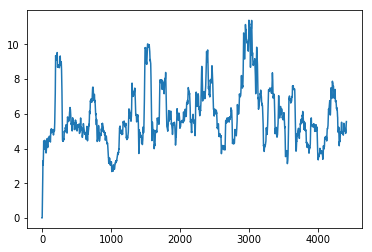

In [37]:
ma_scores = moving_average(scores, window=100)
plt.plot(ma_scores)

Calculate 1-st and 3-d quartile boundaries of scores:

In [38]:
np.percentile(scores, 25), np.percentile(scores, 75), np.median(scores)

(1.0, 8.0, 3.0)

## Q-Learning strategy

Now use the Q-learning method to improve random strategy. 

First, represent current state as a vector of features.

In [39]:
def get_state(obs):
    v = []
    x,y = obs['player']
    v.append(x)
    v.append(y)
    for x, y in obs['monsters']:
        v.append(x)
        v.append(y)
    for x, y in obs['diamonds']:
        v.append(x)
        v.append(y)
    for x, y in obs['walls']:
        v.append(x)
        v.append(y)
    return v

Next, create a class for Q-Learning method. We need both gamma and alpha parameters as well as dictionary for storing Q-Value estimates for all possible (state, action) pairs. 

Since  keys of the dict should be immutable, we will use tuples as keys.

In [40]:
class QLearn:
    def __init__(self, gamma=0.95, alpha=0.05):
        from collections import defaultdict
        self.gamma = gamma
        self.alpha = alpha
        self.qmap = defaultdict(int)

    def iteration(self, old_state, old_action, reward, new_state, new_possible_actions):
        # Produce iteration step (update Q-Value estimates)
        old_stateaction = tuple(old_state) + (old_action,)
        max_q = max([self.qmap[tuple(new_state) + (a,)] for a in new_possible_actions])
        self.qmap[old_stateaction] = (1-self.alpha)*self.qmap[old_stateaction] + self.alpha*(reward+self.gamma*max_q)
        return

    def best_action(self, state, possible_actions):
        # Get the action with highest Q-Value estimate for specific state
        a, q = max([(a, self.qmap[tuple(state) + (a,)]) for a in possible_actions], key=lambda x: x[1])
        return a

Method `iteration()` of class `QLearn` implements Q-Value iteration of the Q-Learning algorithm
$$
Q_{n+1} (s,a) = (1-\alpha) Q_n (s,a) + \alpha \left(R + \gamma \cdot \max_{a'} Q_n(s',a')\right),
$$
where $s=$ `old_state`, $a=$ `old_action`, $R=$ `reward` after taking action $a$ in state $s$, $s'=$ `new_state`, $a'$ is one of possible actions in the new state $s'$. 

The method updates the Q-value dictionary for the pair $(s,a)$.

To illustrate the work of the method initiate the object and the game, calculate `old_obs` as the initial state of the game and its vector of features `old_state`. 

In [41]:
ql = QLearn(gamma=0.95, alpha=0.05)
old_obs = env.reset()
print('old_obs: ', old_obs)
old_state = get_state(old_obs)
print('old_state: ', old_state)
print('Q-function: ', ql.qmap)

old_obs:  {'reward': 0, 'total_score': 0, 'end_game': False, 'player': (3, 0), 'monsters': [(1, 3)], 'diamonds': [(0, 0)], 'walls': [], 'possible_actions': [5, 6, 8, 9]}
old_state:  [3, 0, 1, 3, 0, 0]
Q-function:  defaultdict(<class 'int'>, {})


Based on the old state (position of the agent and the monster) select an action. If the action is not appropriate select another action.

Then calculate `new_obs` by running the selected action through the environment and find its vector of features `new_state`.

Extract from `new_obs` the immediate `reward` value and available actions in the new state `new_possible_actions`.

In [42]:
old_action = 2
new_obs = env.make_action(old_action)
print('new_obs: ', new_obs)
new_state = get_state(new_obs)
print('new_state: ', new_state)
reward = new_obs['reward']
print('reward: ', reward)
new_possible_actions = new_obs['possible_actions']
print('new_possible_actions: ', new_possible_actions)
ql.iteration(old_state, old_action,
             reward, new_state, new_possible_actions)
print('Iteration results: ')
ql.qmap

new_obs:  {'reward': 1, 'total_score': 1, 'end_game': False, 'player': (3, 0), 'monsters': [(0, 2)], 'diamonds': [(0, 0)], 'walls': [], 'possible_actions': [5, 6, 8, 9]}
new_state:  [3, 0, 0, 2, 0, 0]
reward:  1
new_possible_actions:  [5, 6, 8, 9]
Iteration results: 


defaultdict(int,
            {(3, 0, 0, 2, 0, 0, 5): 0,
             (3, 0, 0, 2, 0, 0, 6): 0,
             (3, 0, 0, 2, 0, 0, 8): 0,
             (3, 0, 0, 2, 0, 0, 9): 0,
             (3, 0, 1, 3, 0, 0, 2): 0.05})

The updated Q-value dictionary contains the new value for `old_state` and zero values corresponding to the new state and all available actions in it.

The second method `best_action()` selects the action with the highest Q-value. 

Now implement $\varepsilon$-greedy strategy for the agent. The strategy selects random action with probability $\varepsilon$ and the best known action with probability $1-\varepsilon$.

In [43]:
def strategy(ql, state, possible_actions, eps=0.0):
    if random.random() < eps:
        # select random action
        action = random.choice(possible_actions)
    else:
        # select action with max Q-Value estimate
        action = ql.best_action(state, possible_actions)
    return action

The following function uses the strategy and updates Q-Value estimates while playing `n_games` training games:

In [44]:
def play_and_train(eps, n_games, ql, training, scores):
    for i in range(n_games):
        obs = env.reset() # restart game:
        state = get_state(obs)
        while not obs['end_game']:
            # select next action using strategy
            action = strategy(ql, state, obs['possible_actions'], eps=eps)
            new_obs = env.make_action(action)
            new_state = get_state(new_obs)
            if training:
                # update Q-Value estimates
                ql.iteration(state, action, obs['reward'], 
                             new_state, new_obs['possible_actions'])
            obs = new_obs
            state = new_state
        scores.append(obs['total_score'])
    return

Finally, combine everything to train the agent using descending values of $\varepsilon$ in the exploration policy.

In [ ]:
### Make n_games lower if you get MemoryError

ql = QLearn(gamma=0.95, alpha=0.05)
train_scores = []  # container for results
n_games = 100000  # number of games per eps
eps_list = [0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05, 0.0]
for eps in eps_list:
    print('Training with eps = {} ...'.format(eps))
    play_and_train(eps, n_games, ql, training=True, scores=train_scores)
print('Done.')

Training with eps = 0.9 ...
Training with eps = 0.7 ...
Training with eps = 0.5 ...
Training with eps = 0.3 ...
Training with eps = 0.2 ...
Training with eps = 0.1 ...


Show how average score has changed during the process of training:

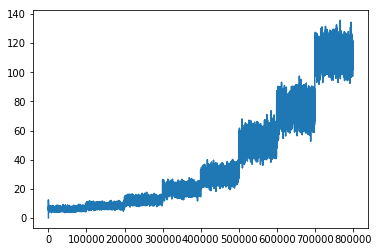

In [25]:
ma_train_scores = moving_average(train_scores)
plt.plot(ma_train_scores)

Now check scores for the trained model:

In [26]:
test_scores=[]
n_games = 1000
play_and_train(0, n_games, ql, training=False, scores=test_scores)

Plot moving average of the scores.

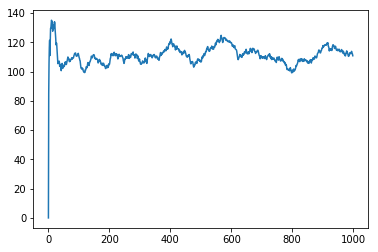

In [27]:
ma_test_scores = moving_average(test_scores)
plt.plot(ma_test_scores)

Calculate first and third quartiles of the scores and the median:

In [28]:
np.percentile(test_scores, 25), np.percentile(test_scores, 75), np.median(test_scores)

(63.0, 160.0, 130.0)

Q-Learning gave significant improvement with respect to random strategy. 

The estimated Q-value function can be extracted from the object as `ql.qmap` member:

In [29]:
ql.qmap

defaultdict(int,
            {(3, 2, 2, 2, 2, 1, 4): 26.076021082819278,
             (3, 2, 2, 2, 2, 1, 5): 1.792095977466062,
             (3, 2, 2, 2, 2, 1, 6): 19.306444754863037,
             (3, 2, 2, 2, 2, 1, 7): 1.287487484354917,
             (3, 2, 2, 2, 2, 1, 8): 1.170433347574392,
             (3, 2, 2, 2, 2, 1, 9): 1.2386041481111973,
             (3, 3, 1, 3, 2, 1, 4): 28.097859991185686,
             (2, 1, 2, 1, 0, 3, 1): 0,
             (2, 1, 2, 1, 0, 3, 2): 0,
             (2, 1, 2, 1, 0, 3, 3): 0,
             (2, 1, 2, 1, 0, 3, 4): 0,
             (2, 1, 2, 1, 0, 3, 5): 0,
             (2, 1, 2, 1, 0, 3, 6): 0,
             (2, 1, 2, 1, 0, 3, 7): 0,
             (2, 1, 2, 1, 0, 3, 8): 0,
             (2, 1, 2, 1, 0, 3, 9): 0,
             (3, 1, 1, 1, 0, 1, 4): 23.812077205683142,
             (3, 1, 1, 1, 0, 1, 5): 25.275745076577003,
             (3, 1, 1, 1, 0, 1, 6): 26.978155862876193,
             (3, 1, 1, 1, 0, 1, 7): 23.234463109353367,
             (3, 1,

Show the agent's strategy in real time.

In [30]:
obs = env.reset()
env.render()
state = get_state(obs)
while not obs['end_game']:
    time.sleep(0.1)
    # select best next action using Q-Learning (no random component here, eps=0)
    action = strategy(ql, state, obs['possible_actions'], eps=0)
    obs = env.make_action(action)
    state = get_state(obs)
    env.render()

print('Total score = {}'.format(obs['total_score']))

Total score = 190


In [31]:
env.close()

The estimated Q-value function for this simple game on $4 \times 4$-field is very large.

In [32]:
len(ql.qmap)

24000

Note that when the game is more complex than 1 monster and 1 diamond the size of `ql.qmap` is **extremely large**. 

In general case number of all possible states can be estimated as $(a\cdot b)^{1+N_\text{monsters}+N_\text{diamonds} +N_\text{walls}}$, where $(a,b)$ is the shape of the field. Multiply it by $9$ to get an estimate to all state-action pairs. 

Billions of games will have to be played for each $\varepsilon$ to reach every state. 

It is evident, that proposed solution is not well-scalable. **Deep neural network** (**DQN**) approach has to be used to approximate Q-Values for all possible actions given current state $s$.